<a href="https://colab.research.google.com/github/marongkang/MLeveryday/blob/main/MLEveryday13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#多层感知(MLP,Multilayer Perceptron)
使用PyTorch实现

#OverView
$z_2=XW_1$  
$a_2=f(z_2)$  
$z_3=a_2W_2$  
$\hat{y}=softmax(z_3)$

where:  
*  $X=输入|∈\mathbb{R}^{NXD}(D为特征数量)$)  
*  $W_1=第一层权重|∈\mathbb{R}^{DXH}(H是隐含层在第一层的单元数量)$  
*  $z_2=第一层权重的输出∈\mathbb{R}^{NXH}$  
*  $f=非线性激活函数$
*  $a_2=应用在第一层输出的激活值|∈\mathbb{R}^{NXD}$  
*  $W_2=第二层权重|\in\mathbb{R}^{HXC}(C为类别数量)$
*  $\hat{y}=预测|∈\mathbb{NXC}(N为采样数量)$

**MLP**
*  **目的**: 对于**非线性**数据输入,预测类别的概率  
*  **优势**:处理非线性模式
*  **劣势**:
 * 容易过拟合
 * 计算精度取决于网络体积
 * 可解释性差
*  多样性 

#Training

步骤:

1. 随机初始化模型权重$W$
2. 给予模型$X$算出概率
3. 比较预测值$\hat{y}$和真实值$y$,使用损失函数确定损失值$J$(此处使用的是交叉熵(Cross Entropy Loss)).
 *  $z_2=XW_1$  
 *  $a_2=max(0,z_2)$  
 *  $z_3=a_2W_2$  
 *  $\hat{y}=softmax(z_3)$
 *  $J(θ)=-∑_iy_iln(\hat{y_i})$ 
4. 计算损失$J(\theta)$w.r.t对模型权重的梯度
 *  $\frac{∂J}{∂W_{2j}}=a_2\hat{y},\frac{∂J}{∂W_{2y}}=a_2(\hat{y}-1)$
 *  $\frac{∂J}{∂W_1}=\frac{∂J}{∂\hat{y}}\frac{∂\hat{y}}{∂a_2}\frac{∂a_2}{∂z_2}\frac{∂z_2}{∂W_1}=W_2(∂scores)(∂ReLU)X$ 
5. 应用反向传播法(backpropagation)到梯度下降更新权重$W$.这些更新减少错误类别的概率,增加正确类别的概率
 * $W_i=W_i-\alpha\frac{∂J}{∂W_i}$
6. 重复2-4,直到模型收敛

#数据

In [ ]:
!pip3 install torch torchvision

In [ ]:
#!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
#%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
#from d2l import torch as d2l
from argparse import  Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm_notebook

#d2l.use_svg_display()

In [ ]:
# Arguments
args = Namespace(
  seed=123,
  num_samples_per_class=500,
  dimensions=2,
  num_classes=3,
  train_size=0.75,
  test_size=0.25,
  num_hidden_units=100,
  learning_rate=1e-0,
  regularization=1e-3,
  num_epochs=200,
)
np.random.seed(args.seed)

In [ ]:
def generate_data(num_samples_per_class,dimensions,num_classes):
  X_origin=np.zeros((num_samples_per_class*num_classes,dimensions))
  y=np.zeros(num_samples_per_class*num_classes,dtype='uint8')
  for j in range(num_classes):
    ix=range(num_samples_per_class*j,num_samples_per_class*(j+1))
    r=np.linspace(0.0,1,num_samples_per_class)
    t=np.linspace(j*4,(j+1)*4,num_samples_per_class)+np.random.randn(num_samples_per_class)*0.2
    X_origin[ix]=np.c_[r*np.sin(t),r*np.cos(t)]
    y[ix]=j
  X=np.hstack([X_origin])

  return X,y

In [ ]:
X, y = generate_data(num_samples_per_class=args.num_samples_per_class, 
            dimensions=args.dimensions, num_classes=args.num_classes)
print ("X: {0}".format(X))
print ("y: {0}".format(np.shape(y)))

X: [[-0.00000000e+00  0.00000000e+00]
 [ 4.12824878e-04  1.96102620e-03]
 [ 2.90837400e-04  3.99744995e-03]
 ...
 [-5.54796456e-01  8.27164388e-01]
 [-4.58349743e-01  8.86516505e-01]
 [-2.14117896e-01  9.76807825e-01]]
y: (1500,)


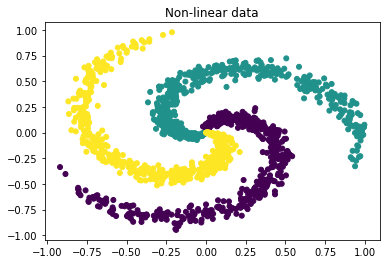

In [ ]:
#plt.figure(dpi=100)
plt.title("Non-linear data")
plt.scatter(X[:,0],X[:,1],c=y,s=25)
plt.show()

In [ ]:
#convert to tensor
X=torch.from_numpy(X).float()
y=torch.from_numpy(y).long()

In [ ]:
#shuffle
shuffle_indicies=torch.LongTensor(random.sample(range(0,len(X)),len(X)))
X=X[shuffle_indicies]
y=y[shuffle_indicies]

#split datasets
test_start_idx=int(len(X)*args.train_size)
X_train=X[:test_start_idx]
y_train=y[:test_start_idx]
X_test=X[test_start_idx:]
y_test=y[test_start_idx:]
print("train_size:{}\ntest_size:{}".format(len(X_train),len(X_test)))

train_size:1125
test_size:375


#使用线性模型强行拟合

In [ ]:
#logistic regression
class LogisticClassifier(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim):
    super(LogisticClassifier,self).__init__()
    self.fc1=nn.Linear(input_dim,hidden_dim)
    self.fc2=nn.Linear(hidden_dim,output_dim)
  
  def forward(self,x_in,apply_softmax=False):
    a_1=self.fc1(x_in)
    y_pred=self.fc2(a_1)

    if apply_softmax:
      y_pred=F.softmax(y_pred,dim=1)
    return y_pred

In [ ]:
model=LogisticClassifier(input_dim=args.dimensions,
             hidden_dim=args.num_hidden_units,
             output_dim=args.num_classes)
model.named_modules

<bound method Module.named_modules of LogisticClassifier(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>

In [ ]:
#根据损失函数优化optimization
Loss_fun=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=args.learning_rate)#Adam optimizer 一般优于SGD

In [ ]:
#accuracy
def get_accuracy(y_pred,y_target):
  n_correct=torch.eq(y_pred,y_target).sum().item()
  accuracy=n_correct/len(y_pred)*100
  return accuracy

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release
from d2l import torch as d2l
from IPython import display
% matplotlib inline

  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-_mp2rwtd
  Running command git clone -q https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-_mp2rwtd
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Running command git submodule update --init --recursive -q
  Created wheel for d2l: filename=d2l-2.0.0b0-py3-none-any.whl size=80071 sha256=f3ea96aaa18cc204b097a5e1e5a06b89942df6a7211467e4fe5a389e012f5d61
  Stored in directory: /tmp/pip-ephem-wheel-cache-sy16tk4c/wheels/73/f4/42/d2b85ca46d85a241d6aa57c1c24027de2d2258202bb67945f9
Successfully built d2l


In [ ]:
class Animator:
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
            ylim=None, xscale='linear', yscale='linear',
            fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
            figsize=(3.5, 2.5)):
    if legend is None:
      legend=[]
    d2l.use_svg_display()
    self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    self.config_axes = lambda: d2l.set_axes(
      self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    self.X, self.Y, self.fmts = None, None, fmts
  
  def add(self, x, y):
    # 向图表中添加多个数据点
    if not hasattr(y, "__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x, "__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a, b) in enumerate(zip(x, y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y, fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)

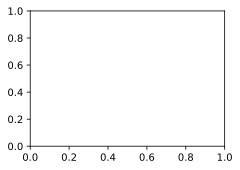

In [ ]:
animator=Animator(xlabel='epoch', xlim=[1, args.num_epochs], ylim=[0.3, 0.9],
            legend=['train loss', 'train acc', 'test acc'])

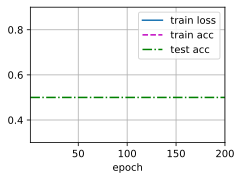

In [ ]:
#训练
for epoch in range(args.num_epochs):
  y_pred=model(X_train)
  _,pred=y_pred.max(dim=1)
  accuracy=get_accuracy(pred.long(),y_train)

  loss=Loss_fun(y_pred,y_train)
  
  animator.add(epoch+1,(loss,accuracy,0.5))

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()



In [ ]:
_,pred_train=model(X_train,apply_softmax=True).max(dim=1)
_,pred_test=model(X_test,apply_softmax=True).max(dim=1)